In [5]:
%%writefile large_batch_training.py

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import argparse
from torch.utils.data import random_split
from google.colab import files

def compute_mean_std(dataset):
    """Compute the mean and std of CIFAR-100 dataset.

    Args:
        dataset: A dataset derived from `torch.utils.data.Dataset`,
                 such as `cifar100_training_dataset` or `cifar100_test_dataset`.

    Returns:
        A tuple containing (mean, std) for the entire dataset.
    """

    # Extract images and labels
    data_r = np.stack([np.array(dataset[i][0])[:, :, 0] for i in range(len(dataset))])
    data_g = np.stack([np.array(dataset[i][0])[:, :, 1] for i in range(len(dataset))])
    data_b = np.stack([np.array(dataset[i][0])[:, :, 2] for i in range(len(dataset))])

    # Compute mean and std
    mean = np.mean(data_r), np.mean(data_g), np.mean(data_b)
    std = np.std(data_r), np.std(data_g), np.std(data_b)

    return mean, std

# Define LeNet-5 architecture
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 64, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 384)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(384, 192)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x

# Device setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize model
net = LeNet5().to(device)

# Optimizer Subclasses
class LARS(optim.Optimizer):
    def __init__(self, params, lr, momentum=0.9, weight_decay=0, trust_coefficient=0.001):
        # Initialize the optimizer with the learning rate, momentum, weight decay, and trust coefficient
        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay, trust_coefficient=trust_coefficient)
        super(LARS, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            # If a closure is provided, evaluate it (commonly used for re-evaluating loss)
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                   # Skip parameters that have no gradient
                    continue
                grad = p.grad.data # Get the gradient of the parameter
                # Retrieve or initialize the optimizer's internal state
                state = self.state[p]
                if len(state) == 0:
                    state['momentum_buffer'] = torch.clone(grad).detach()
                # Apply weight decay directly to the gradient
                if group['weight_decay'] != 0:
                    grad.add_(p.data, alpha=group['weight_decay'])
                # Compute the norms of the parameter and its gradient
                param_norm = torch.norm(p.data)
                grad_norm = torch.norm(grad)
                # Compute local learning rate based on the trust coefficient and norms
                if param_norm > 0 and grad_norm > 0:
                    local_lr = group['trust_coefficient'] * param_norm / (grad_norm + 1e-8)
                    grad = grad.mul(local_lr) # Scale the gradient with the local learning rate
                # Update the momentum buffer
                momentum_buffer = state['momentum_buffer']
                momentum_buffer.mul_(group['momentum']).add_(grad) #Momentum update
                state['momentum_buffer'] = momentum_buffer
                # Update the parameter
                p.data.add_(momentum_buffer, alpha=-group['lr']) # Gradient descent step with learning rate
        return loss

class LAMB(optim.Optimizer):
    def __init__(self, params, lr, weight_decay=0, betas=(0.9, 0.999), eps=1e-8):
        # Initialize the optimizer with learning rate, weight decay, betas for moment updates, and epsilon for stability
        defaults = dict(lr=lr, weight_decay=weight_decay, betas=betas, eps=eps)
        super(LAMB, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            # If a closure is provided, evaluate it
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    # Skip parameters that have no gradient
                    continue
                grad = p.grad.data # Get the gradient of the parameter
                # Retrieve or initialize the optimizer's internal state
                state = self.state[p]
                # Initialize state
                if len(state) == 0:
                    # Initialize the state (step counter, first moment, second moment)
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data) # First moment (mean of gradients)
                    state['exp_avg_sq'] = torch.zeros_like(p.data) # Second moment (mean of squared gradients)
                exp_avg = state['exp_avg']
                exp_avg_sq = state['exp_avg_sq']
                beta1, beta2 = group['betas']  # Coefficients for moment updates
                state['step'] += 1 # Increment step count
                step = state['step']
                # Decay the first and second moment running average coefficients
                # Update first and second moments
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1) # Exponential moving average of gradients
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2) # Exponential moving average of squared gradients
                # Correct bias in the first and second moments
                bias_correction1 = 1 - beta1 ** step
                bias_correction2 = 1 - beta2 ** step
                corrected_exp_avg = exp_avg / bias_correction1
                corrected_exp_avg_sq = exp_avg_sq / bias_correction2
                # Compute the denominator for scaling the update
                denom = corrected_exp_avg_sq.sqrt().add_(group['eps']) # Stability epsilon
                # Compute the step update
                update = corrected_exp_avg / denom
                # Apply weight decay directly to the parameters
                if group['weight_decay'] != 0:
                    update.add_(p.data, alpha=group['weight_decay'])
                # Compute the trust ratio (norm of parameters vs norm of update)
                param_norm = torch.norm(p.data)
                update_norm = torch.norm(update)
                trust_ratio = 1.0  # Default trust ratio
                if param_norm > 0 and update_norm > 0:
                    trust_ratio = param_norm / update_norm
                # Update the parameters
                p.data.add_(update, alpha=-group['lr'] * trust_ratio)
        return loss


# Command-line arguments
parser = argparse.ArgumentParser(description='Train with Large-Batch Optimizers')
parser.add_argument('--optimizer', type=str, default='SGDM', choices=['SGDM', 'AdamW', 'LARS', 'LAMB'],
                    help='Choose optimizer')
parser.add_argument('--batch-size', type=int, default=128, help='Batch size')
parser.add_argument('--momentum', type=float, default=0.9, help='Momentum for SGDM and LARS')
parser.add_argument('--weight-decay', type=float, default=1e-5, help='Weight decay')
parser.add_argument('--b1', type=float, default=0.9, help='Beta1 for AdamW')
parser.add_argument('--b2', type=float, default=0.999, help='Beta2 for AdamW')
parser.add_argument('--trust-coefficient', type=float, default=0.001, help='Trust coefficient for LARS')
parser.add_argument('--epochs', type=int, default=150, help='Number of epochs')
parser.add_argument('--warmup-epochs', type=int, default=5, help='Number of epochs')
args = parser.parse_args()


torch.manual_seed(42) # Set the seed for reproducibility
torch.cuda.manual_seed_all(42) # Set the seed for reproducibility on GPU

# use the same mean and std to add consistency to all datasets
data = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
mean, std = compute_mean_std(data)

# Load and split CIFAR-100 dataset
train_transform = transforms.Compose([
  transforms.RandomCrop(32, padding=4),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean, std)
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size, shuffle=False, num_workers=2)


# Fixed parameter from paper [18] to calculate the square root LR scaling value
# base_lr = 5 / (2**3 * 10**3)
# reference_batch_size = 512
#scaled_lr = base_lr * (args.batch_size / reference_batch_size) ** 0.5

# Mapping optimizers
if args.optimizer == 'SGDM':
    base_lr = 1e-3
    reference_batch_size = 64
    scaled_lr = base_lr * (args.batch_size / reference_batch_size) ** 0.5
    optimizer = optim.SGD(net.parameters(), lr=scaled_lr, momentum=args.momentum, weight_decay=args.weight_decay)
elif args.optimizer == 'AdamW':
    base_lr = 5e-4
    reference_batch_size = 64
    scaled_lr = base_lr * (args.batch_size / reference_batch_size) ** 0.5
    optimizer = optim.AdamW(net.parameters(), lr=scaled_lr, betas=(args.b1, args.b2), weight_decay=args.weight_decay)
elif args.optimizer == 'LARS':
    base_lr = 1e-2
    reference_batch_size = 64
    scaled_lr = base_lr * (args.batch_size / reference_batch_size) ** 0.5
    optimizer = LARS(net.parameters(), lr=scaled_lr, momentum=args.momentum, weight_decay=args.weight_decay, trust_coefficient=args.trust_coefficient)
elif args.optimizer == 'LAMB':
    base_lr = 5e-4
    reference_batch_size = 64
    scaled_lr = base_lr * (args.batch_size / reference_batch_size) ** 0.5
    optimizer = LAMB(net.parameters(), lr=scaled_lr, weight_decay=args.weight_decay)

criterion = nn.CrossEntropyLoss()

# Scheduler initialization
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=args.epochs - args.warmup_epochs)

# Training Function
def train_model(optimizer, scheduler, model, criterion, trainloader , testloader, device, epochs, save_checkpoint_interval=10):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    for epoch in range(epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()
        train_loss = running_loss / len(trainloader)
        train_accuracy = 100. * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        '''
        # Early Stopping
        if val_loss < best_val_loss:
          best_val_loss = val_loss
          epochs_no_improve = 0
        else:
          epochs_no_improve += 1

        if epochs_no_improve == patience:
          print("Early stopping!")
          break
        '''

        # Test
        correct_test, total_test, test_loss = 0, 0, 0.0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total_test += labels.size(0)
                correct_test += predicted.eq(labels).sum().item()
        test_loss /= len(testloader)
        test_losses.append(test_loss)
        test_accuracy = 100. * correct_test / total_test
        test_accuracies.append(test_accuracy)

        if epoch >= args.warmup_epochs:
            scheduler.step()  # Trigger cosine decay
        else:
            warmup_factor = (epoch + 1) / args.warmup_epochs
            lr = warmup_factor * scaled_lr
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

        # Checkpointing
        if (epoch + 1) % save_checkpoint_interval == 0:
            checkpoint_filename = f'checkpoint_epoch_{epoch + 1}.pth'
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': loss.item(),
            }
            checkpoint_path = os.path.join('./', checkpoint_filename)
            torch.save(checkpoint, checkpoint_path)
            print(f'Checkpoint saved at epoch {epoch + 1}: {checkpoint_path}')

            # Download the checkpoint
            files.download(checkpoint_filename)

        print(f'Epoch {epoch+1}/{epochs}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    return train_losses, test_losses, train_accuracies, test_accuracies

# Train the model
print(f"--- Train with {args.optimizer} ---")
train_loss, test_loss, train_acc, test_acc = train_model(optimizer, scheduler, net, criterion, trainloader, testloader, device, args.epochs)

# Save model
torch.save(net.state_dict(), f'net_{args.optimizer}.pth')

# Plot results
# Plot Training Loss
plt.figure(figsize=(6, 4))
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('train_loss.png')
plt.show()

# Plot Training Accuracy
plt.figure(figsize=(6, 4))
plt.plot(train_acc, label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.savefig('train_accuracy.png')
plt.show()

# Plot Test Loss
plt.figure(figsize=(6, 4))
plt.plot(test_loss, label='Test Loss')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('test_loss.png')
plt.show()

# Plot Test Accuracy
plt.figure(figsize=(6, 4))
plt.plot(test_acc, label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.savefig('test_accuracy.png')
plt.show()

Overwriting large_batch_training.py


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
--- Train with SGDM ---
Epoch 1/150, Train Acc: 0.88%, Test Acc: 1.00%
Epoch 1/150, Train Loss: 4.6052, Test Loss: 4.6034
Epoch 2/150, Train Acc: 1.00%, Test Acc: 1.02%
Epoch 2/150, Train Loss: 4.6030, Test Loss: 4.6025
Epoch 3/150, Train Acc: 0.93%, Test Acc: 1.09%
Epoch 3/150, Train Loss: 4.6017, Test Loss: 4.6005
Epoch 4/150, Train Acc: 1.14%, Test Acc: 1.37%
Epoch 4/150, Train Loss: 4.5987, Test Loss: 4.5963
Epoch 5/150, Train Acc: 1.58%, Test Acc: 2.07%
Epoch 5/150, Train Loss: 4.5921, Test Loss: 4.5859
Epoch 6/150, Train Acc: 2.06%, Test Acc: 2.35%
Epoch 6/150, Train Loss: 4.5742, Test Loss: 4.5559
Epoch 7/150, Train Acc: 2.28%, Test Acc: 2.93%
Epoch 7/150, Train Loss: 4.5301, Test Loss: 4.4943
Epoch 8/150, Train Acc: 3.32%, Test Acc: 3.75%
Epoch 8/150, Train Loss: 4.4561, Test Loss: 4.3887
Epoch 9/150, Train Acc: 5.10%, Test Acc: 6.62%
Epoch 9/150, Train Loss: 4.3217

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 10/150, Train Acc: 6.97%, Test Acc: 8.06%
Epoch 10/150, Train Loss: 4.1642, Test Loss: 4.0731
Epoch 11/150, Train Acc: 7.72%, Test Acc: 8.42%
Epoch 11/150, Train Loss: 4.0832, Test Loss: 4.0252
Epoch 12/150, Train Acc: 8.56%, Test Acc: 9.69%
Epoch 12/150, Train Loss: 4.0315, Test Loss: 3.9698
Epoch 13/150, Train Acc: 9.37%, Test Acc: 10.12%
Epoch 13/150, Train Loss: 3.9907, Test Loss: 3.9279
Epoch 14/150, Train Acc: 9.95%, Test Acc: 11.02%
Epoch 14/150, Train Loss: 3.9504, Test Loss: 3.8796
Epoch 15/150, Train Acc: 10.76%, Test Acc: 11.74%
Epoch 15/150, Train Loss: 3.9010, Test Loss: 3.8361
Epoch 16/150, Train Acc: 11.40%, Test Acc: 12.89%
Epoch 16/150, Train Loss: 3.8588, Test Loss: 3.7801
Epoch 17/150, Train Acc: 12.11%, Test Acc: 13.23%
Epoch 17/150, Train Loss: 3.8114, Test Loss: 3.7464
Epoch 18/150, Train Acc: 12.90%, Test Acc: 14.19%
Epoch 18/150, Train Loss: 3.7726, Test Loss: 3.7009
Epoch 19/150, Train Acc: 13.45%, Test Acc: 14.64%
Epoch 19/150, Train Loss: 3.7331, Test L

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 20/150, Train Acc: 13.73%, Test Acc: 15.49%
Epoch 20/150, Train Loss: 3.7034, Test Loss: 3.6307
Epoch 21/150, Train Acc: 14.35%, Test Acc: 15.16%
Epoch 21/150, Train Loss: 3.6730, Test Loss: 3.6103
Epoch 22/150, Train Acc: 15.10%, Test Acc: 16.53%
Epoch 22/150, Train Loss: 3.6385, Test Loss: 3.5734
Epoch 23/150, Train Acc: 15.56%, Test Acc: 16.83%
Epoch 23/150, Train Loss: 3.6076, Test Loss: 3.5366
Epoch 24/150, Train Acc: 16.14%, Test Acc: 18.00%
Epoch 24/150, Train Loss: 3.5665, Test Loss: 3.5020
Epoch 25/150, Train Acc: 16.45%, Test Acc: 17.93%
Epoch 25/150, Train Loss: 3.5427, Test Loss: 3.4698
Epoch 26/150, Train Acc: 17.41%, Test Acc: 18.08%
Epoch 26/150, Train Loss: 3.5020, Test Loss: 3.4533
Epoch 27/150, Train Acc: 17.94%, Test Acc: 18.40%
Epoch 27/150, Train Loss: 3.4711, Test Loss: 3.4330
Epoch 28/150, Train Acc: 18.19%, Test Acc: 19.60%
Epoch 28/150, Train Loss: 3.4481, Test Loss: 3.3898
Epoch 29/150, Train Acc: 18.79%, Test Acc: 19.04%
Epoch 29/150, Train Loss: 3.4145

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 30/150, Train Acc: 19.33%, Test Acc: 19.96%
Epoch 30/150, Train Loss: 3.3859, Test Loss: 3.3583
Epoch 31/150, Train Acc: 19.81%, Test Acc: 21.15%
Epoch 31/150, Train Loss: 3.3623, Test Loss: 3.3060
Epoch 32/150, Train Acc: 20.13%, Test Acc: 21.19%
Epoch 32/150, Train Loss: 3.3397, Test Loss: 3.2943
Epoch 33/150, Train Acc: 20.61%, Test Acc: 21.41%
Epoch 33/150, Train Loss: 3.3121, Test Loss: 3.2813
Epoch 34/150, Train Acc: 21.08%, Test Acc: 22.29%
Epoch 34/150, Train Loss: 3.2885, Test Loss: 3.2369
Epoch 35/150, Train Acc: 21.48%, Test Acc: 22.37%
Epoch 35/150, Train Loss: 3.2673, Test Loss: 3.2336
Epoch 36/150, Train Acc: 21.98%, Test Acc: 23.27%
Epoch 36/150, Train Loss: 3.2468, Test Loss: 3.1895
Epoch 37/150, Train Acc: 22.33%, Test Acc: 22.33%
Epoch 37/150, Train Loss: 3.2184, Test Loss: 3.2103
Epoch 38/150, Train Acc: 23.01%, Test Acc: 23.23%
Epoch 38/150, Train Loss: 3.1928, Test Loss: 3.1825
Epoch 39/150, Train Acc: 23.30%, Test Acc: 23.80%
Epoch 39/150, Train Loss: 3.1776

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 40/150, Train Acc: 23.49%, Test Acc: 24.10%
Epoch 40/150, Train Loss: 3.1619, Test Loss: 3.1379
Epoch 41/150, Train Acc: 23.94%, Test Acc: 24.65%
Epoch 41/150, Train Loss: 3.1373, Test Loss: 3.1371
Epoch 42/150, Train Acc: 24.13%, Test Acc: 24.59%
Epoch 42/150, Train Loss: 3.1193, Test Loss: 3.1192
Epoch 43/150, Train Acc: 24.46%, Test Acc: 25.54%
Epoch 43/150, Train Loss: 3.0995, Test Loss: 3.0661
Epoch 44/150, Train Acc: 25.05%, Test Acc: 26.20%
Epoch 44/150, Train Loss: 3.0696, Test Loss: 3.0383
Epoch 45/150, Train Acc: 25.31%, Test Acc: 26.21%
Epoch 45/150, Train Loss: 3.0557, Test Loss: 3.0398
Epoch 46/150, Train Acc: 25.63%, Test Acc: 27.54%
Epoch 46/150, Train Loss: 3.0416, Test Loss: 2.9884
Epoch 47/150, Train Acc: 25.78%, Test Acc: 26.90%
Epoch 47/150, Train Loss: 3.0250, Test Loss: 2.9832
Epoch 48/150, Train Acc: 25.96%, Test Acc: 26.58%
Epoch 48/150, Train Loss: 3.0118, Test Loss: 3.0015
Epoch 49/150, Train Acc: 26.55%, Test Acc: 28.75%
Epoch 49/150, Train Loss: 2.9923

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 50/150, Train Acc: 27.15%, Test Acc: 28.09%
Epoch 50/150, Train Loss: 2.9681, Test Loss: 2.9303
Epoch 51/150, Train Acc: 27.30%, Test Acc: 28.69%
Epoch 51/150, Train Loss: 2.9618, Test Loss: 2.9138
Epoch 52/150, Train Acc: 27.52%, Test Acc: 28.97%
Epoch 52/150, Train Loss: 2.9432, Test Loss: 2.8905
Epoch 53/150, Train Acc: 27.43%, Test Acc: 28.20%
Epoch 53/150, Train Loss: 2.9345, Test Loss: 2.9350
Epoch 54/150, Train Acc: 27.88%, Test Acc: 28.32%
Epoch 54/150, Train Loss: 2.9251, Test Loss: 2.9067
Epoch 55/150, Train Acc: 28.20%, Test Acc: 29.59%
Epoch 55/150, Train Loss: 2.9146, Test Loss: 2.8666
Epoch 56/150, Train Acc: 28.58%, Test Acc: 30.29%
Epoch 56/150, Train Loss: 2.8945, Test Loss: 2.8344
Epoch 57/150, Train Acc: 29.02%, Test Acc: 29.95%
Epoch 57/150, Train Loss: 2.8758, Test Loss: 2.8324
Epoch 58/150, Train Acc: 29.34%, Test Acc: 29.80%
Epoch 58/150, Train Loss: 2.8626, Test Loss: 2.8297
Epoch 59/150, Train Acc: 29.26%, Test Acc: 30.40%
Epoch 59/150, Train Loss: 2.8519

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 60/150, Train Acc: 29.65%, Test Acc: 30.68%
Epoch 60/150, Train Loss: 2.8432, Test Loss: 2.8070
Epoch 61/150, Train Acc: 29.56%, Test Acc: 31.00%
Epoch 61/150, Train Loss: 2.8353, Test Loss: 2.7965
Epoch 62/150, Train Acc: 30.09%, Test Acc: 31.06%
Epoch 62/150, Train Loss: 2.8130, Test Loss: 2.7984
Epoch 63/150, Train Acc: 30.13%, Test Acc: 31.28%
Epoch 63/150, Train Loss: 2.8124, Test Loss: 2.7780
Epoch 64/150, Train Acc: 30.50%, Test Acc: 31.93%
Epoch 64/150, Train Loss: 2.7907, Test Loss: 2.7589
Epoch 65/150, Train Acc: 30.65%, Test Acc: 30.79%
Epoch 65/150, Train Loss: 2.7819, Test Loss: 2.7813
Epoch 66/150, Train Acc: 30.84%, Test Acc: 31.53%
Epoch 66/150, Train Loss: 2.7682, Test Loss: 2.7808
Epoch 67/150, Train Acc: 30.96%, Test Acc: 31.99%
Epoch 67/150, Train Loss: 2.7601, Test Loss: 2.7459
Epoch 68/150, Train Acc: 31.33%, Test Acc: 32.72%
Epoch 68/150, Train Loss: 2.7501, Test Loss: 2.7212
Epoch 69/150, Train Acc: 31.45%, Test Acc: 32.15%
Epoch 69/150, Train Loss: 2.7415

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 70/150, Train Acc: 31.54%, Test Acc: 32.96%
Epoch 70/150, Train Loss: 2.7416, Test Loss: 2.7137
Epoch 71/150, Train Acc: 32.13%, Test Acc: 33.20%
Epoch 71/150, Train Loss: 2.7128, Test Loss: 2.6876
Epoch 72/150, Train Acc: 32.22%, Test Acc: 33.70%
Epoch 72/150, Train Loss: 2.7120, Test Loss: 2.6848
Epoch 73/150, Train Acc: 32.44%, Test Acc: 33.30%
Epoch 73/150, Train Loss: 2.6960, Test Loss: 2.6719
Epoch 74/150, Train Acc: 32.42%, Test Acc: 34.42%
Epoch 74/150, Train Loss: 2.6855, Test Loss: 2.6473
Epoch 75/150, Train Acc: 33.05%, Test Acc: 33.91%
Epoch 75/150, Train Loss: 2.6776, Test Loss: 2.6491
Epoch 76/150, Train Acc: 33.03%, Test Acc: 34.39%
Epoch 76/150, Train Loss: 2.6606, Test Loss: 2.6277
Epoch 77/150, Train Acc: 33.25%, Test Acc: 34.56%
Epoch 77/150, Train Loss: 2.6540, Test Loss: 2.6257
Epoch 78/150, Train Acc: 33.29%, Test Acc: 34.24%
Epoch 78/150, Train Loss: 2.6491, Test Loss: 2.6464
Epoch 79/150, Train Acc: 33.54%, Test Acc: 34.40%
Epoch 79/150, Train Loss: 2.6417

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 80/150, Train Acc: 33.67%, Test Acc: 34.73%
Epoch 80/150, Train Loss: 2.6275, Test Loss: 2.6089
Epoch 81/150, Train Acc: 33.84%, Test Acc: 35.05%
Epoch 81/150, Train Loss: 2.6194, Test Loss: 2.5994
Epoch 82/150, Train Acc: 34.18%, Test Acc: 34.73%
Epoch 82/150, Train Loss: 2.6080, Test Loss: 2.6107
Epoch 83/150, Train Acc: 34.38%, Test Acc: 35.61%
Epoch 83/150, Train Loss: 2.5963, Test Loss: 2.5740
Epoch 84/150, Train Acc: 34.35%, Test Acc: 35.13%
Epoch 84/150, Train Loss: 2.5980, Test Loss: 2.5871
Epoch 85/150, Train Acc: 34.56%, Test Acc: 35.26%
Epoch 85/150, Train Loss: 2.5886, Test Loss: 2.5786
Epoch 86/150, Train Acc: 34.89%, Test Acc: 35.71%
Epoch 86/150, Train Loss: 2.5761, Test Loss: 2.5605
Epoch 87/150, Train Acc: 35.09%, Test Acc: 35.63%
Epoch 87/150, Train Loss: 2.5698, Test Loss: 2.5486
Epoch 88/150, Train Acc: 35.10%, Test Acc: 35.68%
Epoch 88/150, Train Loss: 2.5624, Test Loss: 2.5582
Epoch 89/150, Train Acc: 35.21%, Test Acc: 36.17%
Epoch 89/150, Train Loss: 2.5568

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 90/150, Train Acc: 35.60%, Test Acc: 35.74%
Epoch 90/150, Train Loss: 2.5458, Test Loss: 2.5474
Epoch 91/150, Train Acc: 35.57%, Test Acc: 36.18%
Epoch 91/150, Train Loss: 2.5403, Test Loss: 2.5234
Epoch 92/150, Train Acc: 35.74%, Test Acc: 36.42%
Epoch 92/150, Train Loss: 2.5348, Test Loss: 2.5187
Epoch 93/150, Train Acc: 35.76%, Test Acc: 36.79%
Epoch 93/150, Train Loss: 2.5276, Test Loss: 2.5241
Epoch 94/150, Train Acc: 36.08%, Test Acc: 36.94%
Epoch 94/150, Train Loss: 2.5185, Test Loss: 2.5146
Epoch 95/150, Train Acc: 35.99%, Test Acc: 36.77%
Epoch 95/150, Train Loss: 2.5186, Test Loss: 2.5143
Epoch 96/150, Train Acc: 35.86%, Test Acc: 36.80%
Epoch 96/150, Train Loss: 2.5146, Test Loss: 2.5108
Epoch 97/150, Train Acc: 36.13%, Test Acc: 36.67%
Epoch 97/150, Train Loss: 2.5077, Test Loss: 2.5054
Epoch 98/150, Train Acc: 36.49%, Test Acc: 36.70%
Epoch 98/150, Train Loss: 2.5013, Test Loss: 2.5012
Epoch 99/150, Train Acc: 36.64%, Test Acc: 37.07%
Epoch 99/150, Train Loss: 2.4904

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 100/150, Train Acc: 36.68%, Test Acc: 36.89%
Epoch 100/150, Train Loss: 2.4865, Test Loss: 2.4894
Epoch 101/150, Train Acc: 36.94%, Test Acc: 37.05%
Epoch 101/150, Train Loss: 2.4816, Test Loss: 2.4888
Epoch 102/150, Train Acc: 36.81%, Test Acc: 37.38%
Epoch 102/150, Train Loss: 2.4802, Test Loss: 2.4756
Epoch 103/150, Train Acc: 36.91%, Test Acc: 37.31%
Epoch 103/150, Train Loss: 2.4761, Test Loss: 2.4820
Epoch 104/150, Train Acc: 37.04%, Test Acc: 37.34%
Epoch 104/150, Train Loss: 2.4655, Test Loss: 2.4773
Epoch 105/150, Train Acc: 37.20%, Test Acc: 37.76%
Epoch 105/150, Train Loss: 2.4651, Test Loss: 2.4622
Epoch 106/150, Train Acc: 37.19%, Test Acc: 37.62%
Epoch 106/150, Train Loss: 2.4647, Test Loss: 2.4699
Epoch 107/150, Train Acc: 37.18%, Test Acc: 37.66%
Epoch 107/150, Train Loss: 2.4613, Test Loss: 2.4711
Epoch 108/150, Train Acc: 37.36%, Test Acc: 37.76%
Epoch 108/150, Train Loss: 2.4535, Test Loss: 2.4599
Epoch 109/150, Train Acc: 37.39%, Test Acc: 37.44%
Epoch 109/150

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 110/150, Train Acc: 37.53%, Test Acc: 38.17%
Epoch 110/150, Train Loss: 2.4446, Test Loss: 2.4501
Epoch 111/150, Train Acc: 37.66%, Test Acc: 37.87%
Epoch 111/150, Train Loss: 2.4432, Test Loss: 2.4589
Epoch 112/150, Train Acc: 37.64%, Test Acc: 37.96%
Epoch 112/150, Train Loss: 2.4374, Test Loss: 2.4554
Epoch 113/150, Train Acc: 37.64%, Test Acc: 37.94%
Epoch 113/150, Train Loss: 2.4362, Test Loss: 2.4513
Epoch 114/150, Train Acc: 37.97%, Test Acc: 38.15%
Epoch 114/150, Train Loss: 2.4253, Test Loss: 2.4476
Epoch 115/150, Train Acc: 37.72%, Test Acc: 38.28%
Epoch 115/150, Train Loss: 2.4308, Test Loss: 2.4446
Epoch 116/150, Train Acc: 38.08%, Test Acc: 38.32%
Epoch 116/150, Train Loss: 2.4250, Test Loss: 2.4482
Epoch 117/150, Train Acc: 38.03%, Test Acc: 38.21%
Epoch 117/150, Train Loss: 2.4273, Test Loss: 2.4395
Epoch 118/150, Train Acc: 38.18%, Test Acc: 38.18%
Epoch 118/150, Train Loss: 2.4246, Test Loss: 2.4403
Epoch 119/150, Train Acc: 38.16%, Test Acc: 38.43%
Epoch 119/150

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 120/150, Train Acc: 38.23%, Test Acc: 38.36%
Epoch 120/150, Train Loss: 2.4134, Test Loss: 2.4335
Epoch 121/150, Train Acc: 38.34%, Test Acc: 38.37%
Epoch 121/150, Train Loss: 2.4116, Test Loss: 2.4330
Epoch 122/150, Train Acc: 38.39%, Test Acc: 38.25%
Epoch 122/150, Train Loss: 2.4144, Test Loss: 2.4327
Epoch 123/150, Train Acc: 38.30%, Test Acc: 38.53%
Epoch 123/150, Train Loss: 2.4102, Test Loss: 2.4325
Epoch 124/150, Train Acc: 38.50%, Test Acc: 38.75%
Epoch 124/150, Train Loss: 2.4064, Test Loss: 2.4246
Epoch 125/150, Train Acc: 38.44%, Test Acc: 38.65%
Epoch 125/150, Train Loss: 2.4060, Test Loss: 2.4304
Epoch 126/150, Train Acc: 38.59%, Test Acc: 38.24%
Epoch 126/150, Train Loss: 2.4059, Test Loss: 2.4273
Epoch 127/150, Train Acc: 38.50%, Test Acc: 38.49%
Epoch 127/150, Train Loss: 2.4044, Test Loss: 2.4294
Epoch 128/150, Train Acc: 38.64%, Test Acc: 38.46%
Epoch 128/150, Train Loss: 2.4031, Test Loss: 2.4298
Epoch 129/150, Train Acc: 38.52%, Test Acc: 38.57%
Epoch 129/150

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 130/150, Train Acc: 38.74%, Test Acc: 38.70%
Epoch 130/150, Train Loss: 2.3962, Test Loss: 2.4245
Epoch 131/150, Train Acc: 38.52%, Test Acc: 38.72%
Epoch 131/150, Train Loss: 2.4049, Test Loss: 2.4234
Epoch 132/150, Train Acc: 38.53%, Test Acc: 38.41%
Epoch 132/150, Train Loss: 2.3952, Test Loss: 2.4221
Epoch 133/150, Train Acc: 38.91%, Test Acc: 38.44%
Epoch 133/150, Train Loss: 2.3910, Test Loss: 2.4266
Epoch 134/150, Train Acc: 38.68%, Test Acc: 38.37%
Epoch 134/150, Train Loss: 2.3939, Test Loss: 2.4208
Epoch 135/150, Train Acc: 38.71%, Test Acc: 38.49%
Epoch 135/150, Train Loss: 2.3940, Test Loss: 2.4259
Epoch 136/150, Train Acc: 38.97%, Test Acc: 38.57%
Epoch 136/150, Train Loss: 2.3905, Test Loss: 2.4193
Epoch 137/150, Train Acc: 38.74%, Test Acc: 38.60%
Epoch 137/150, Train Loss: 2.3958, Test Loss: 2.4210
Epoch 138/150, Train Acc: 38.93%, Test Acc: 38.55%
Epoch 138/150, Train Loss: 2.3883, Test Loss: 2.4189
Epoch 139/150, Train Acc: 39.00%, Test Acc: 38.49%
Epoch 139/150

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 140/150, Train Acc: 38.83%, Test Acc: 38.65%
Epoch 140/150, Train Loss: 2.3942, Test Loss: 2.4184
Epoch 141/150, Train Acc: 38.96%, Test Acc: 38.67%
Epoch 141/150, Train Loss: 2.3861, Test Loss: 2.4189
Epoch 142/150, Train Acc: 38.83%, Test Acc: 38.49%
Epoch 142/150, Train Loss: 2.3897, Test Loss: 2.4187
Epoch 143/150, Train Acc: 38.57%, Test Acc: 38.56%
Epoch 143/150, Train Loss: 2.3900, Test Loss: 2.4179
Epoch 144/150, Train Acc: 38.78%, Test Acc: 38.62%
Epoch 144/150, Train Loss: 2.3910, Test Loss: 2.4187
Epoch 145/150, Train Acc: 38.83%, Test Acc: 38.56%
Epoch 145/150, Train Loss: 2.3916, Test Loss: 2.4178
Epoch 146/150, Train Acc: 38.98%, Test Acc: 38.62%
Epoch 146/150, Train Loss: 2.3879, Test Loss: 2.4178
Epoch 147/150, Train Acc: 38.98%, Test Acc: 38.63%
Epoch 147/150, Train Loss: 2.3881, Test Loss: 2.4182
Epoch 148/150, Train Acc: 38.75%, Test Acc: 38.62%
Epoch 148/150, Train Loss: 2.3909, Test Loss: 2.4179
Epoch 149/150, Train Acc: 38.82%, Test Acc: 38.61%
Epoch 149/150

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 150/150, Train Acc: 39.02%, Test Acc: 38.61%
Epoch 150/150, Train Loss: 2.3853, Test Loss: 2.4180


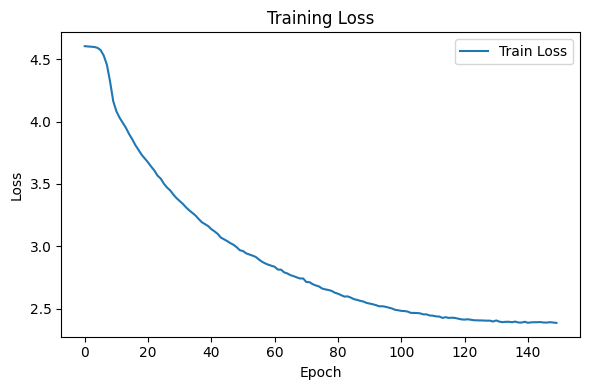

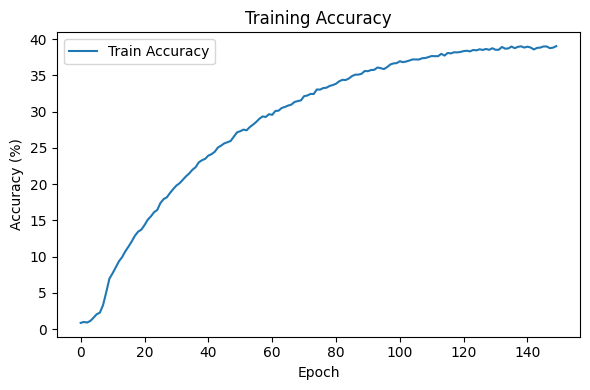

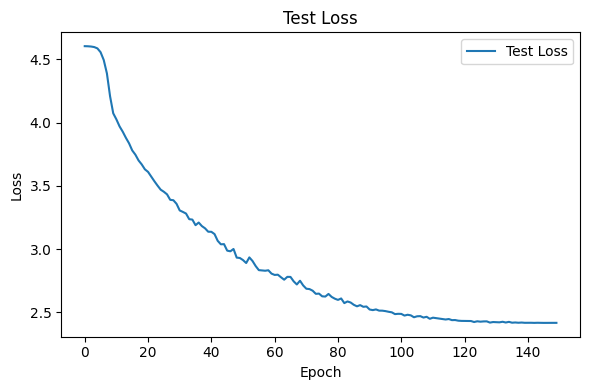

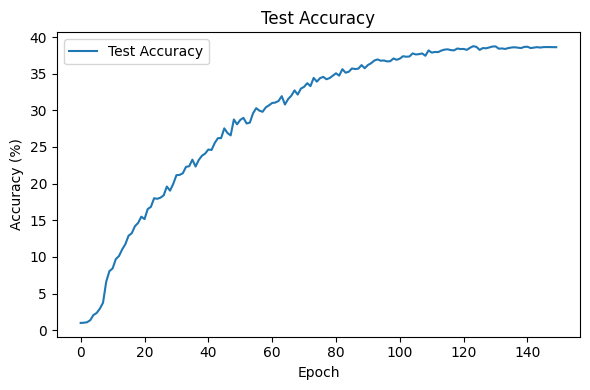

<Figure size 640x480 with 0 Axes>

In [6]:
%run large_batch_training.py --optimizer SGDM --batch-size 1024 --weight-decay 4e-4